# Part 2, XGBoost

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.cross_validation import KFold, train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

/home/phe002/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/phe002/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In this part, we are going to train, tune and validate an XGBoost model. We are not going to use the test set from Kaggle: it is unlabeled and is designed for Kaggle score evaluation.

We start with the initial data preprocessing, then train a simple XGBoost model to set a baseline score and, finally, iterate over the ways to improve the baseline score.

## A note on computational complexity
Though I tried to reduce the complexity of the following models, we should understand that there is no silver bullet and a number of heavy computations like a grid search is required. 

These computations are essential for the project and cannot be simply ignored or reduced. If you feel that these calculations take way more time than you have (sometimes they do), you can simply use precalculated pickled models.

If you are not going to use pretrained models, change the following flag to `False`:

In [2]:
USE_PRETRAINED = False

## Data preprocessing

Simple data loading and transformations:

In [3]:
train = pd.read_csv('train.csv')

We log-transform the target variable, as discussed earlier.

In [4]:
train['log_loss'] = np.log(train['loss'])

Divide categorical and numerical features:

In [5]:
features = [x for x in train.columns if x not in ['id','loss', 'log_loss']]

cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['id','loss', 'log_loss']]
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['id','loss', 'log_loss']]

print "Categorical features:", len(cat_features)
print "Numerical features:", len(num_features)

Categorical features: 116
Numerical features: 14


And use a label encoder for categorical features:

In [6]:
ntrain = train.shape[0]

train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
    
print "Xtrain:", train_x.shape
print "ytrain:", train_y.shape

Xtrain: (188318, 130)
ytrain: (188318,)


## Simple XGBoost Model

To start with, we train a baseline XGBoost model just to understand how well the whole training goes. As we aren't going to submit the results to Kaggle, we should cross validate them locally. Again, to make sure that an average PC can handle this, we now limit ourselves to 3-fold CV (we'll increase it to 5-fold CV later), 50 trees and stop if a CV error hasn't decreased in 10 rounds.

We use a custom evaluation function `xg_eval_mae` which calculates MAE, but works with our log-transformed data and uses XGBoost's `DMatrix`:

In [7]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

### Model

We need to transform the initial dataset into the DMatrix, the native format of XGBoost.

In [8]:
dtrain = xgb.DMatrix(train_x, train['log_loss'])

We use some average set of parameters to make XGBoost work:

In [14]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3,
    'n_jobs':10
}

Now we run XGBoost and cross validate the results via the built-in `xgb.cv` function. We use our `xg_eval_mae` function for calculating the loss (MAE).

In [10]:
%time

if USE_PRETRAINED: 
    with open('pretrained/xgb_bst_cv1.pkl', 'rb') as f:
        bst_cv1 = pickle.load(f)
        
else:
    bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                    feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print 'CV score:', bst_cv1.iloc[-1,:]['test-mae-mean']

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs
CV score: 1219.572998


We got the first baseline result: `MAE=1219.57`. Since our calculations fluctuate from time to time, I'm providing the score for pretrained models. Your score may differ slightly if you choose to run all computations.

We can plot the training and test errors:

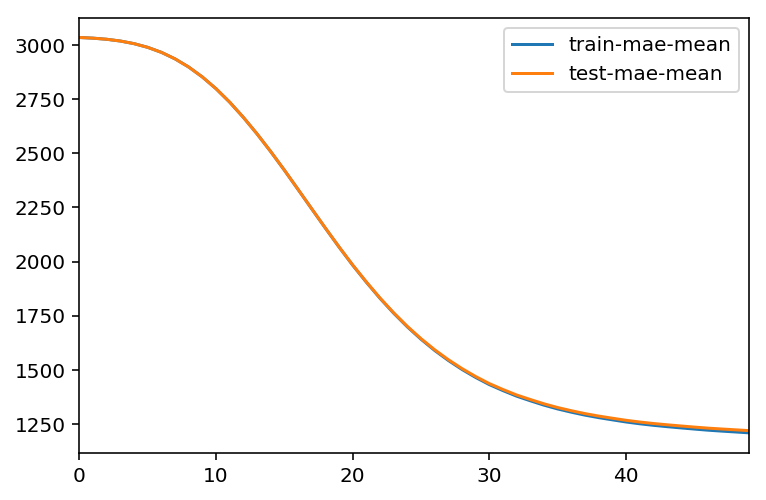

In [11]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()

Our first insights from XGBoost:


* There is no overfitting, the training and test losses are very close to each other


* By the round \#50 the loss is still decreasing.


We may safely proceed and train a bit more complex model with 100 trees.

In [16]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3,
    'nthread':10
}

In [17]:
%%time
if USE_PRETRAINED:
     with open('pretrained/xgb_bst_cv2.pkl', 'rb') as f:
        bst_cv2 = pickle.load(f)
else:
    bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                    nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                    early_stopping_rounds=10)

print 'CV score:', bst_cv2.iloc[-1,:]['test-mae-mean']

CV score: 1171.77067033
CPU times: user 3min 25s, sys: 2.89 s, total: 3min 28s
Wall time: 22.4 s


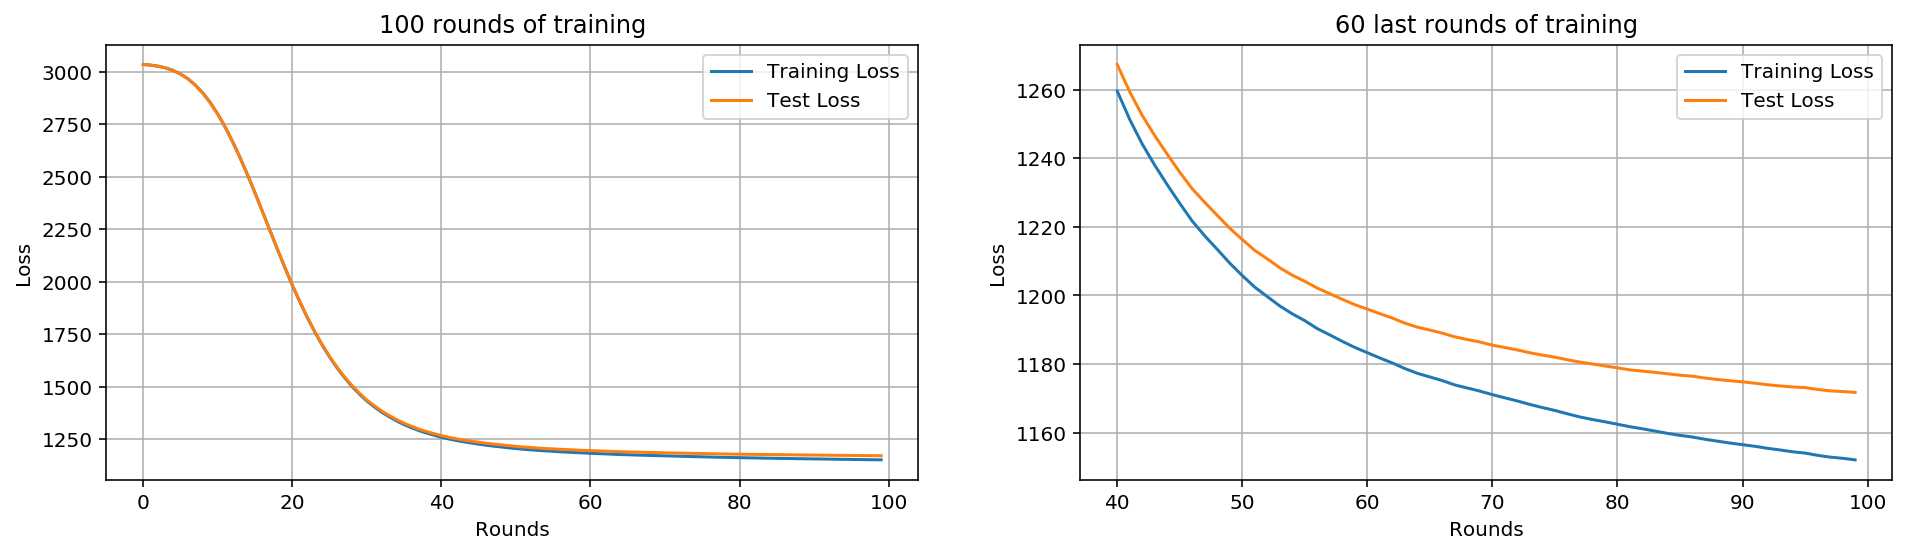

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])

As we see, the gap between training and test loss widens with each new round. While this might not be the best performing model, we are still on the safe side. There is no overfitting, the test loss monotonically decreases with each nwe round.

Now we get a CV score **MAE = 1171.77** (`CV score: 1171.77067033`) which is much better than the score we got first (1219.57). We are now doing better than a baseline model (random forest). Of course, we can increase the number of estimators even further, but we should now concentrate on other hyperparameters and fix `num_boost_round` till the end of tuning.

When we compete on Kaggle, we usually train complex models (one of my models was an ensemble of 8K trees, another one allowed boosting a very large number of trees, but with early stopping turned on). Outside of competition, we can and should look for a tradeoff between the predictive power and computational complexity of our models.

## XGBoost Tuning

### Methodology

Now we have two models: `bst_cv1` (basic) and `bst_cv2` (with more trees). Again, to simplify and accelerate learning, we go on with the basic model, tune and memorize the hyperparameters and implement a new learner with those hyperparameters based on `bst_cv2`.

The final model will get additional base estimators.

Though we limit our tuning to a grid search, there are much more powerful optimization techniques. One of my favorite is Bayesian global optimization implemented in [BayesianOptimization](https://github.com/fmfn/BayesianOptimization) package. This is a smarter and efficient way to find a global extremum (in our case, optimize the hyperparameters space to get the minimum possible MAE) as this algorithm makes intelligent guesses based on past information instead of just exhaustively iterating through the grid.

I suppose that using `BayesianOptimization` is beyond the scope of this Capstone, so we focus on a grid search approach (which does provide good results). From methodological point of view, we'll use [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) as a reference.

* Step 1: Set reasonable initial learining rate and a number of estimators.


* Step 2: Tuning `max_depth` and `min_child_weight`.


* Step 3: Tuning `gamma` to reduce overfitting.


* Step 4: Tuning `subsample` and `colsample_bytree`.


* Step 5: Reducing learning rate `eta`, adding more estimators.

As we use the built-in `GridSearchCV` routine, the simplest way to train XGBoost on it would be to call it via its scikit-learn wrapper interface `xgboost.XGBRegressor`. Unfortunately, it's missing several important properties and functions (e.g. custom eval function or the option to minimize this function instead of maximizing) so we have to write our own wrapper.

In [23]:
# To follow conventional function names in sklearn, we implement fit and predict functions
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

We'll also use a custom scorer which works with log-transformed values:

In [24]:
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

Now we can test our new class:

In [25]:
bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50,nthread=10)

In [26]:
bst.kfold(train_x, train_y, nfold=5)

test-mae-mean     1219.601831
test-mae-std         9.622902
train-mae-mean    1209.563525
train-mae-std        2.370022
Name: 49, dtype: float64

This looks similar to what we got earlier with 50 trees, so that we are safe to continue.

### Step 1: Fixing learning rate and number of estimators

We've seen from the message above that the CV error hasn't decreased in 10 rounds. This allows us increase the number of `num_boost_round`, as well as decrease `eta`, but we now fix these parameters to 50 and 0.1 respectively to reduce training time.

Further on, we return to the discussion of `num_boost_round` and `eta`.

### Step 2: Tuning max_depth and min_child_weight

These parameters have the highest impact on the performance of XGBoost, thus, they should be tuned first. We briefly overview them:


* `max_depth`: maximum depth of a tree. Increasing this value will make the model more complex and also prone to overfitting. [Recommended](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) depth is between 3-10 which is reasonable: a tree with few levels won't likely to capture non-linear features. On the other hand, too complex tree will probably overfit.


* `min_child_weight`: a regularization parameter. Stops the tree building process if the tree partition results in a leaf node with the sum of instance weight less than defined in `min_child_weight`. If set too large, a tree may get underfitted.

In [28]:
xgb_param_grid = {'max_depth': range(4,9), 'min_child_weight': (1,3,6)}

In [29]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_max_depth.pkl', 'rb') as f: 
        grid = pickle.load(f)
else:    
    grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, 
                                         colsample_bytree=0.5, subsample=0.5,nthread=10),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer,n_jobs=10)

    grid.fit(train_x, train_y.values)

CPU times: user 1min 17s, sys: 1.19 s, total: 1min 18s
Wall time: 3min 35s


In [30]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1243.28221, std: 7.10850, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -1243.09817, std: 7.15875, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -1243.29907, std: 7.16987, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -1218.44087, std: 7.89849, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -1218.05072, std: 6.85799, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -1218.14628, std: 6.62355, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -1203.41002, std: 6.20229, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: -1202.19347, std: 6.36582, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -1202.31329, std: 6.00106, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: -1193.42716, std: 6.23152, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -1192.91919, std: 6.15560, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -1191.97026, std: 6.31372, params: {'max_depth': 7, 'min_child_weigh

The best result found by this grid search:

`{'max_depth': 8, 'min_child_weight': 6},
 -1186.5963814064248)`
 
A negative value is a convention of `GridSearchCV` (always search for a maximum).

To understand the relationship between `max_depth` and `min_child_weight`, we draw a contour plot. First, we facilitate retrieving data from `grid.grid_scores_`:

In [31]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [32]:
_, _, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,3)

Now we plot the chart:

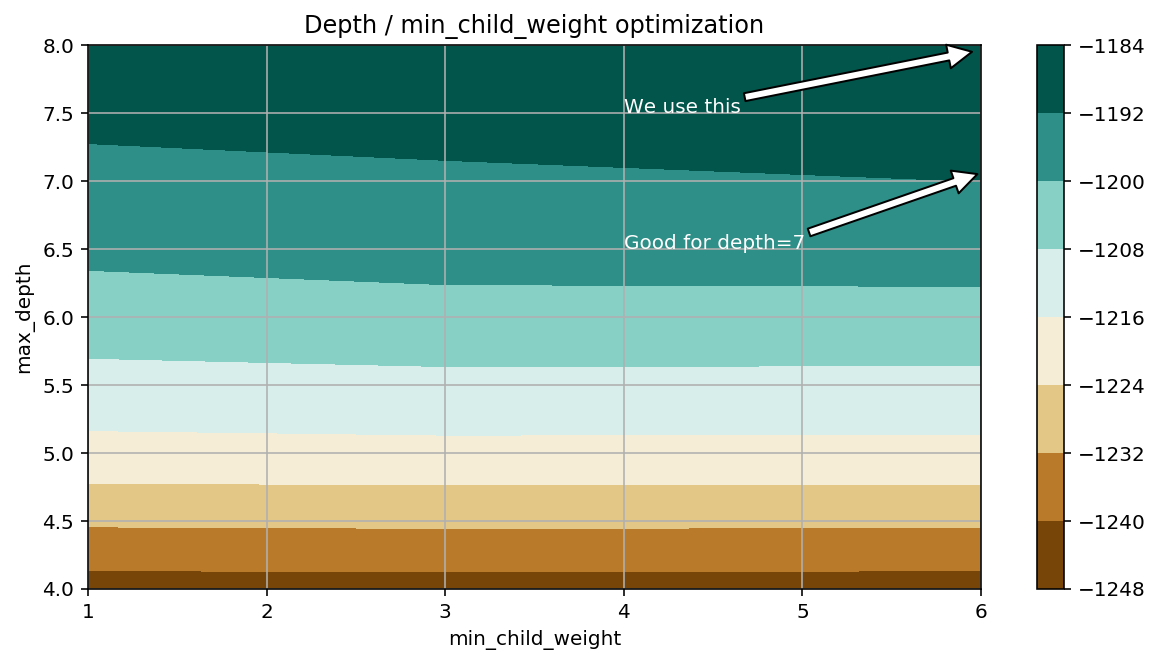

In [33]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this', xy=(5.95, 7.95), xytext=(4, 7.5), arrowprops=dict(facecolor='white'), color='white')
plt.annotate('Good for depth=7', xy=(5.98, 7.05), 
             xytext=(4, 6.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

As we see from the results of grid search, the improvement of score is mostly based on the increase of `max_depth` (the bars on the contour plot are mostly horizontal). `min_child_weight` only slightly influence the score, though, we see that `min_child_weight=6` usually works good. 

One more peculiar observation we may have is that the increase of `min_child_weight` starts to make sense when `max_depth` grows. We can compensate a smaller value of `max_depth` (8 -> 7) by setting `min_child_weight=6` and still get a good score. Thus we optimize the speed of our regressor for production use.

### Step 3: Tuning gamma to reduce overfitting

Now we continue our grid search and start tuning `gamma`. We also take the parameters already tuned above. Adding gamma means that the model now requires a minimum amount of loss reduction to make a further partition.

Let's make a grid search to find an optimal `gamma`. Though our model doesn't seem to suffer from overfitting, tuning `gamma` is [very important](https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/20662/overtuning-hyper-parameters-especially-re-xgboost/118487#post118487) and it's a requirement for more complicated models.

In [34]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_gamma.pkl', 'rb') as f: 
        grid = pickle.load(f)
    
else:
    xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

    grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.5, subsample=0.5,nthread=10),
                        param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

    grid.fit(train_x, train_y.values)

CPU times: user 24min 36s, sys: 15.6 s, total: 24min 52s
Wall time: 2min 35s


In [35]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1186.59638, std: 4.79068, params: {'gamma': 0.0},
  mean: -1186.69135, std: 5.50043, params: {'gamma': 0.1},
  mean: -1187.14651, std: 5.74282, params: {'gamma': 0.2},
  mean: -1187.30515, std: 5.69072, params: {'gamma': 0.30000000000000004},
  mean: -1186.91298, std: 5.55083, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -1186.5963814064248)

In our pretrained model, the optimal value of `gamma=0.2`. Actually, I got different results on different machines (mostly, I got optimal `gamma=0.1`), so that it's really hard to say whether we should pick one or the other.

The conclusion here is to always check your model for overfitting. Further on, we'll use `gamma=0.2`.

### Step 4: Tuning subsample and colsample_bytree

Each single tree in XGBoost is usually trained on a subset of data. `subsample` defines a subsample ratio of training examples per tree, `colsample_bytree` — a subsample ratio of columns when constructing each tree.

Though Kaggle competitors prefer using a small value of `colsample_bytree`, we are going to abide by our methodology and test larger values of `colsample_bytree`. Of course, we may test smaller values, find another local optima and stack several prominent XGBoost models with different `colsample_bytree` or `subsample` values into one ensemble.

In [36]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(5,10)],
                      'colsample_bytree':[ 0.1 * i for i in range(5,10)]}

if USE_PRETRAINED: 
    with open('pretrained/xgb_grid_search_sampling.pkl', 'rb') as f:
        grid = pickle.load(f)
else:
    grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.2, num_boost_round=50, 
                                         max_depth=8, min_child_weight=6,nthread=10),
                        param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
    grid.fit(train_x, train_y.values)

CPU times: user 2h 22min 9s, sys: 1min 20s, total: 2h 23min 30s
Wall time: 14min 52s


In [37]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1187.14651, std: 5.74282, params: {'subsample': 0.5, 'colsample_bytree': 0.5},
  mean: -1183.95696, std: 6.57242, params: {'subsample': 0.6000000000000001, 'colsample_bytree': 0.5},
  mean: -1184.08497, std: 6.63419, params: {'subsample': 0.7000000000000001, 'colsample_bytree': 0.5},
  mean: -1183.60260, std: 6.20877, params: {'subsample': 0.8, 'colsample_bytree': 0.5},
  mean: -1183.55706, std: 5.68026, params: {'subsample': 0.9, 'colsample_bytree': 0.5},
  mean: -1185.17871, std: 6.95500, params: {'subsample': 0.5, 'colsample_bytree': 0.6000000000000001},
  mean: -1183.73137, std: 6.23378, params: {'subsample': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001},
  mean: -1182.89479, std: 6.15776, params: {'subsample': 0.7000000000000001, 'colsample_bytree': 0.6000000000000001},
  mean: -1182.49180, std: 6.28448, params: {'subsample': 0.8, 'colsample_bytree': 0.6000000000000001},
  mean: -1182.89282, std: 5.98104, params: {'subsample': 0.9, 'colsample_bytree': 0.6000

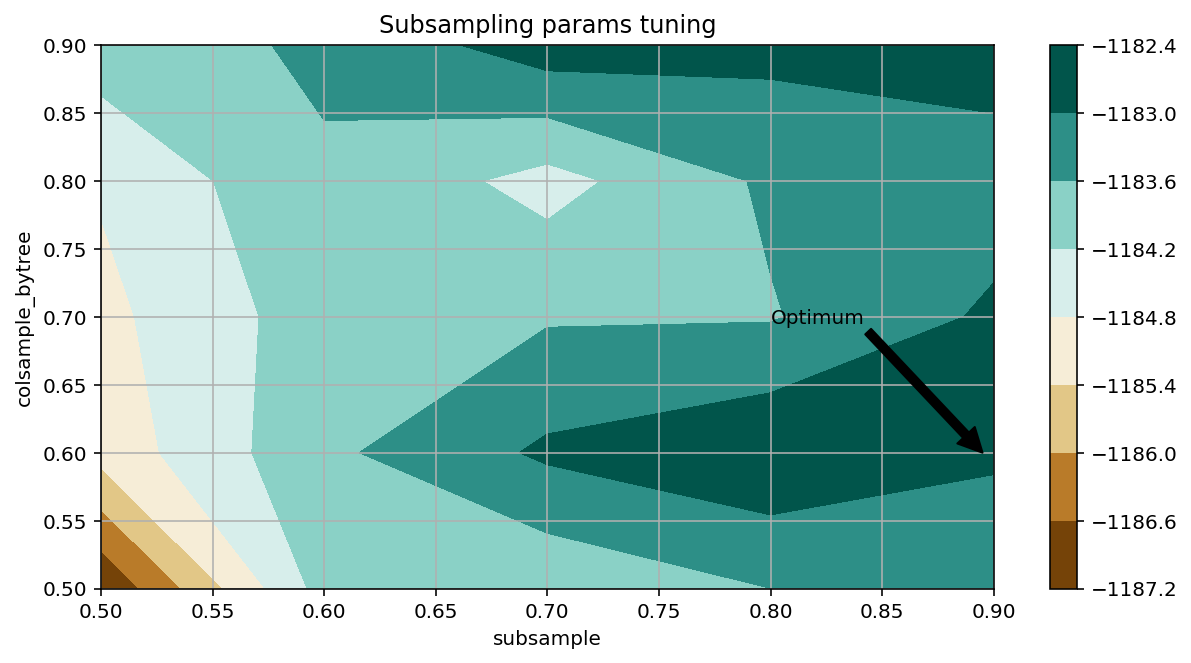

In [38]:
_, _, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,5)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.895, 0.6), xytext=(0.8, 0.695), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show()

In the specific case of current pretrained model, I got the following results:

`{'colsample_bytree': 0.6, 'subsample': 0.9},
 -1183.6672029537717)`

This set of hyper-parameters is unstable and I got a number of other combinations: `{'colsample_bytree': 0.7, 'subsample': 0.9}` or `{'colsample_bytree': 0.9, 'subsample': 0.9}`. I suppose this happens due to the low amount of estimators which doesn't allow the model be more solid. Ideally, we should add more estimators and try again).

### Step 5: Reducing learning rate and adding more trees

The final step in our parameters optimization will be to reduce learning rate and add more estimators at the same time. There is a very good [discussion](https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/20208/is-there-an-easy-way-to-understand-the-learning-rate-in-xgboost/115553) on Kaggle regarding interpretation of learning rate and its relation to the amount of training rounds (which is basically the number of trees we throw at the problem).

What `eta` and `num_boost_round` should we choose? A trivial answer would be to pick several desired learning rates possible and do grid search with several possible values of `num_boost_round`. This is very costly in practice. Alternatively, we can test a few `num_boost_round` candidates and understand when and how the shrinkage of `eta` starts to affect the score. Thus, we can generalize a rule of thumb: what `eta` should be set for the current `num_boost_round`.

We have two options for `num_boost_round` (as we discussed at the start of this analysis): 50 and 100 trees: `num_boost_round=[50, 100]`. We choose several `eta` for each of them: `eta=[0.2,0.1,0.075,0.05,0.04,0.03,0.02,0.01]`.

First, we plot different learning rates for a simpler model (50 trees):

In [39]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_search_eta_50.pkl', 'rb') as f:
        grid = pickle.load(f)
else:      
    xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
    grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.2, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.6, subsample=0.9,nthread=10),
                        param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

    grid.fit(train_x, train_y.values)

CPU times: user 41min 23s, sys: 27.1 s, total: 41min 50s
Wall time: 4min 22s


In [40]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1201.88604, std: 6.07199, params: {'eta': 0.5},
  mean: -1183.46471, std: 5.06894, params: {'eta': 0.4},
  mean: -1167.69374, std: 7.17471, params: {'eta': 0.3},
  mean: -1159.94358, std: 5.87359, params: {'eta': 0.2},
  mean: -1182.89282, std: 5.98104, params: {'eta': 0.1},
  mean: -1265.05782, std: 7.14701, params: {'eta': 0.075},
  mean: -1708.60787, std: 8.33340, params: {'eta': 0.05},
  mean: -2104.08308, std: 8.07369, params: {'eta': 0.04},
  mean: -2545.84043, std: 7.74146, params: {'eta': 0.03}],
 {'eta': 0.2},
 -1159.9435788950157)

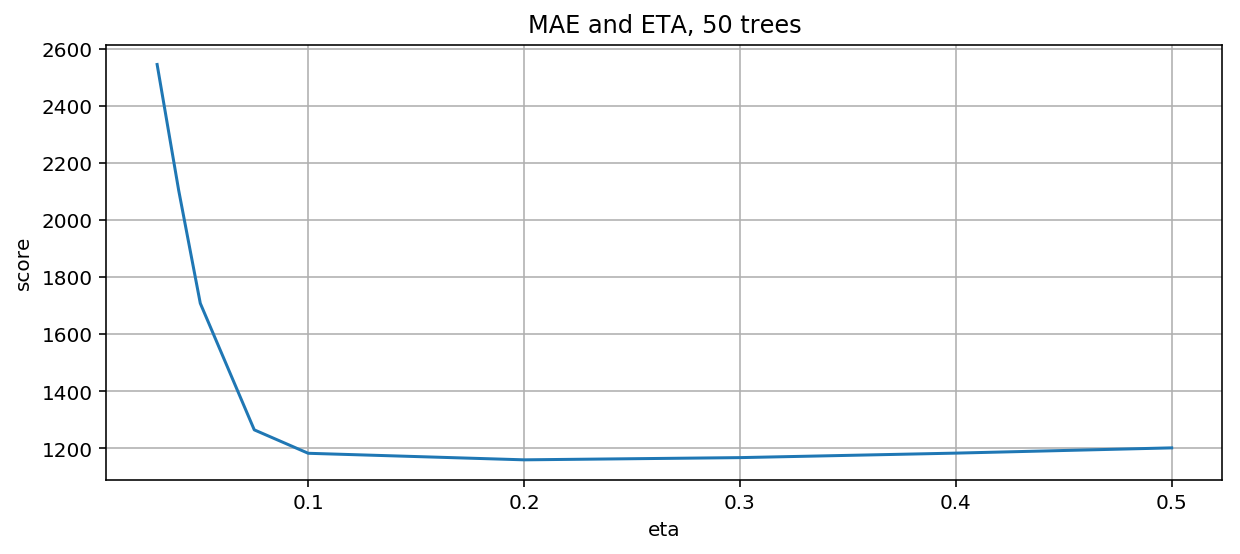

In [41]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

Observing the curve, we understand that `eta < 0.1` doesn't allow the model reach a decent score. In this case, the step would be too small for only 50 trees we have at this time.

We also see that we missed the correct `eta`: instead of 0.1 it should be near 0.2. We won't finetune it further, though. Instead, let's memorize that for `num_boost_round=50` we found `eta=0.2`. As we see, 
`{'eta': 0.2}, -1160.9736284869114` improved our score for the same small amount of trees.

Now, replicate the process for `num_boost_round=100`. We effectively double the amount of trees, let's see how `eta` should be changed.

In [42]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_search_eta_100.pkl', 'rb') as f:
        grid = pickle.load(f)
else:
    xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
    grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.6, subsample=0.9,nthread=10),
                        param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

    grid.fit(train_x, train_y.values)

CPU times: user 1h 17min 24s, sys: 30.3 s, total: 1h 17min 55s
Wall time: 7min 58s


In [43]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1225.71340, std: 5.55392, params: {'eta': 0.5},
  mean: -1197.36520, std: 4.83414, params: {'eta': 0.4},
  mean: -1173.97189, std: 6.43963, params: {'eta': 0.3},
  mean: -1158.71930, std: 6.23232, params: {'eta': 0.2},
  mean: -1152.31074, std: 5.89249, params: {'eta': 0.1},
  mean: -1156.25850, std: 5.82188, params: {'eta': 0.075},
  mean: -1183.65385, std: 6.02994, params: {'eta': 0.05},
  mean: -1242.64897, std: 7.40521, params: {'eta': 0.04},
  mean: -1466.42109, std: 8.50806, params: {'eta': 0.03}],
 {'eta': 0.1},
 -1152.310739800777)

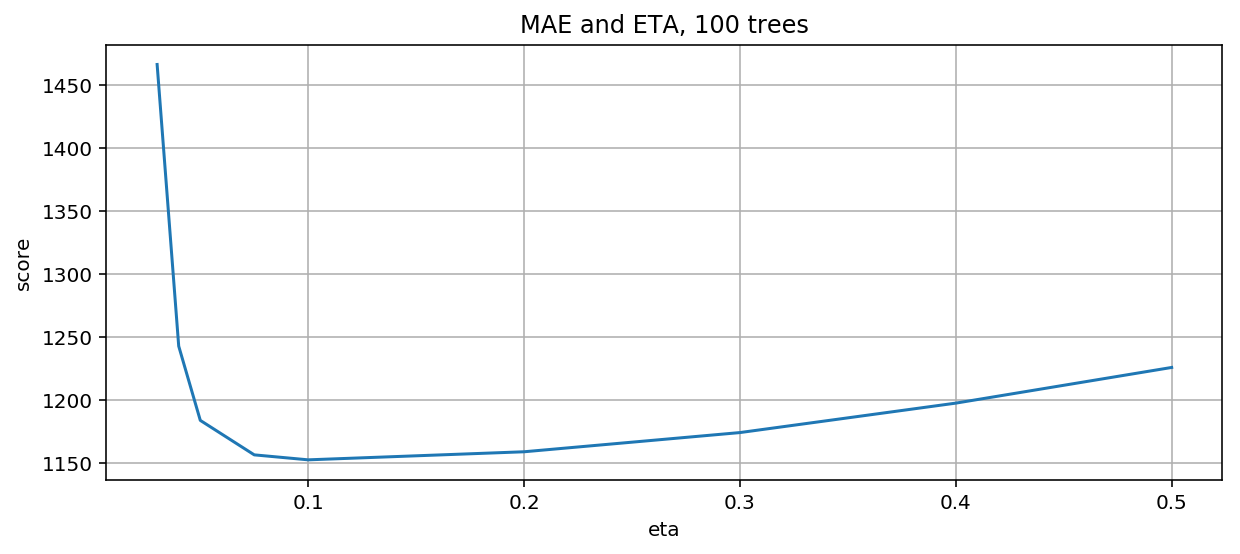

In [44]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 100 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

We now see that the optimal `eta=0.1` and we conclude that doubling the amount of estimators should come with cutting `eta` in half. Of course, this is just a rule of thumb and the real dependency is not a linear one (and not that trivial), but such a rule can work as an educated guess for future models.

Let's train one more XGBoost with just a few `eta` values to confirm this assumption.

In [45]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_search_eta_200.pkl', 'rb') as f:
        grid = pickle.load(f)
else:
    xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
    grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.6, subsample=0.9,nthread=10),
                        param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

    grid.fit(train_x, train_y.values)

CPU times: user 1h 44min 14s, sys: 28.7 s, total: 1h 44min 43s
Wall time: 10min 36s


In [46]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1146.01517, std: 5.76699, params: {'eta': 0.09},
  mean: -1145.61374, std: 5.55433, params: {'eta': 0.08},
  mean: -1145.97316, std: 5.61878, params: {'eta': 0.07},
  mean: -1146.89976, std: 6.06952, params: {'eta': 0.06},
  mean: -1147.82665, std: 6.23111, params: {'eta': 0.05},
  mean: -1152.13819, std: 6.42678, params: {'eta': 0.04}],
 {'eta': 0.08},
 -1145.6137356573054)

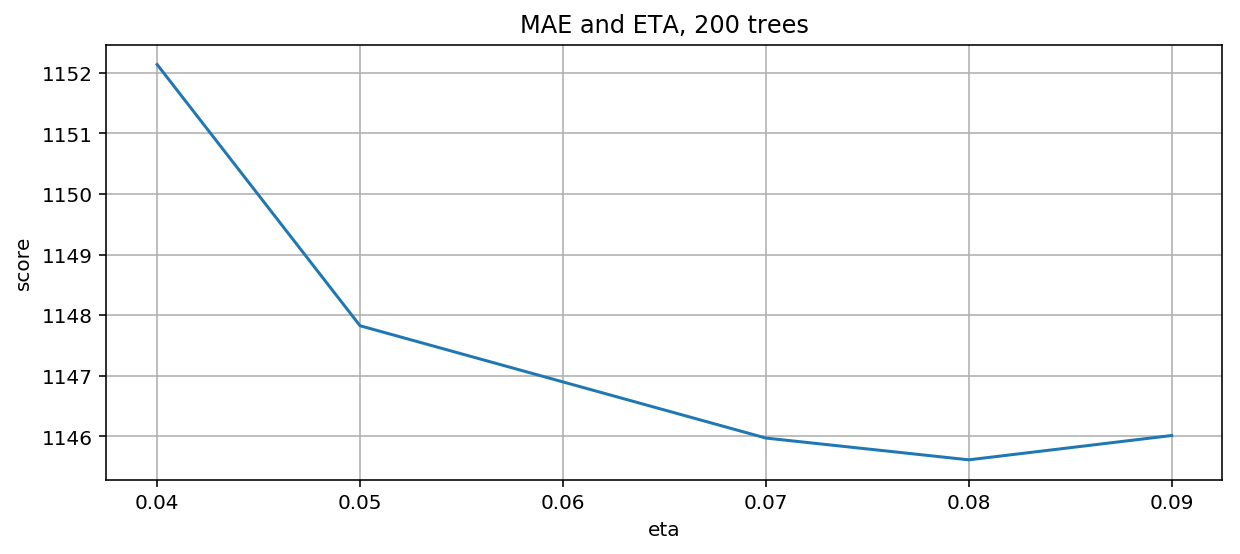

In [47]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 200 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [48]:
%%time

# Final XGBoost model

if USE_PRETRAINED:
    with open('pretrained/xgb_cv_eta_200.pkl', 'rb') as f:
        cv = pickle.load(f)
else:
    bst = XGBoostRegressor(num_boost_round=200, eta=0.07, gamma=0.2, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.6, subsample=0.9,nthread=10)
    cv = bst.kfold(train_x, train_y, nfold=5)

CPU times: user 17min 33s, sys: 6.35 s, total: 17min 39s
Wall time: 1min 49s


In [49]:
cv

test-mae-mean     1146.601733
test-mae-std         8.808277
train-mae-mean    1041.609058
train-mae-std        1.274400
Name: 199, dtype: float64

We see that the best `eta` for 200 trees is 0.07. As we expected, dependency between `eta` and `num_boost_round` is not linear.

It took us quite a while to optimize XGBoost. Let's recall the initial score: **1219.57**. After doing grid search, this model (with fixed `eta` and `num_boost_round`) scored **MAE=1171.77**.

We also found out the relationship between `eta` and `num_boost_round` and progressively trained two more models:

* 100 trees, `eta=0.1`: **MAE=1152.247**
* 200 trees, `eta=0.07`: **MAE=1145.92**

We now found our first model we can use in the final ensemble. Here it is:
`XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6, colsample_bytree=0.6, subsample=0.9, eta=0.07).
`  CV score for the final run of this model: **MAE=1146.998**. As we see, results may fluctuate quite a bit.

## Room for Improvement
Though we improved our score, there is still a great potential to get even better results. I'll just list some of them:


* Fit a more complex XGBoost model by adding even more estimators and reducing `eta` at the same time.


* Use `early_stopping_rounds` instead of `num_boost_round` to limit the training. In this case, we set `eta` to the a small number and make `num_boost_round` very large (up to 100K).


* Run Grid Search on different values of hyperparameters. Say, we could test `0 < colsample_bytree < 0.5` which often fruits good results. The idea is that there is a number of local optima in the hyperparameters space and we should find several of these optima.


* Ensemble several XGBoost models, trained with different hyperparameters. This can be done by bagging (averaging the score of the models), blending and stacking.